In [1]:
import os
import pandas as pd

def parse_content(lines):
    data = {}
    for line in lines:
        # Split each line by ':', stripping any extra whitespace
        if ':' in line:
            column, value = line.strip().split(':', 1)
            data[column.strip()] = float(value.strip()) if value.strip().replace('.', '', 1).isdigit() else value.strip()
    return data

def parse_file(file_path):

    with open(file_path, 'r') as file:
        return parse_content(file.readlines())


# Discrete GPU

In [2]:
directory_path = "../Statistics/RTX4060_1280_720_2"

def read_statistics(folder):
    data_list = []
    for file_name in os.listdir(folder):
        if file_name.endswith('.txt'):
            params = file_name.split(".")[0].split("_")[1:]
            file_path = os.path.join(folder, file_name)
            file_data = parse_file(file_path)
            file_data["Experiment"] = params[3]
            file_data["Model"] = params[1]
            data_list.append(file_data)

    special_columns = ["Model", "Experiment", "Renderer"]
    ms_columns = [
        'Average frame time',
        'Median frame time',
        '99th percentile frame time',
        '1th percentile frame time'
    ]

    df = pd.DataFrame(data_list)
    for column in df.columns:
        if column in special_columns:
            continue
        df[column] = pd.to_numeric(df[column]) 

    for column in ms_columns:
        df[column] *= 1000.0
    return df

df = read_statistics(directory_path)
df = df.sort_values(by="Renderer")


df.head()

,Renderer,Objects count,Total number of vertices,Creation time,Average CPU usage,Max CPU usage,Min CPU usage,Average GPU usage,Max GPU usage,Min GPU usage,...,Average GPU memory usage,Max GPU memory usage,Min GPU memory usage,Average FPS,Average frame time,Median frame time,99th percentile frame time,1th percentile frame time,Experiment,Model
0,DirectX,400.0,0.0,0.560327,11.8177,16.3648,8.55969,95.2399,99.1352,39.68560,...,35.5312,35.5312,35.5312,47.3671,21.111700,21.1644,21.3527,20.5786,1,Bunny
27,DirectX,800.0,0.0,0.414249,22.0649,25.1198,17.09740,17.9921,20.1883,6.09521,...,21.9688,21.9688,21.9688,5935.1500,0.168488,0.1525,0.3553,0.1246,2,Cube
26,DirectX,200.0,0.0,0.395694,21.2293,26.3519,11.40600,21.4043,29.7746,7.86352,...,21.9688,21.9688,21.9688,9722.0600,0.102859,0.0894,0.2590,0.0555,1,Cube
25,DirectX,2000.0,0.0,0.396368,21.8777,25.5846,12.05670,28.1570,41.9652,9.66719,...,21.9727,21.9727,21.9727,2626.5700,0.380724,0.3443,0.6481,0.3163,1,Cube
24,DirectX,400.0,0.0,0.394063,21.9093,23.3947,15.99670,16.1349,17.9570,5.50538,...,21.9688,21.9688,21.9688,7849.1500,0.127402,0.1213,0.3095,0.0680,2,Cube


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
sns.set_palette(sns.dark_palette("white")[1:])

def plot_data(data, config, ax):
    linestyles = {
        "Vulkan": (5, 2),  # Dashed
        "OpenGL": (3, 2, 1, 2),  # Dash-dot
        "DirectX": ''  # Solid (no dashes)
    }

    sns.lineplot(data=data, x=config["x_column"], y=config["y_column"], hue="Renderer", style="Renderer", markers=True, dashes=linestyles, ax=ax)    
    ax.title.set_text(config["title"])
    ax.set_xlabel(config["x_label"])
    ax.set_ylabel(config["y_label"])
    ax.legend(title='Rendering API')

def plot_grid(plot_config, figsize=(12, 8), title="", output=None):
    if type(plot_config) != list:
        dim_to_add = 2
    elif type(plot_config[0]) != list:
        dim_to_add = 1
    else:
        dim_to_add = 0

    for i in range(dim_to_add):
        plot_config = [plot_config]
    
    columns = max(len(row) for row in plot_config)
    rows = len(plot_config)
    fig, axs = plt.subplots(ncols=columns, nrows=rows, figsize=figsize)
    if rows == 1:
        axs = [axs]
    if columns == 1:
        for i in range(len(axs)):
            axs[i] = [axs[i]]

    for i in range(len(plot_config)):
        for j in range(len(plot_config[i])):
            config = plot_config[i][j]
            config["function"](config["data"], config["title"], axs[i][j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(title)
    if output is not None:
        fig.savefig(output, dpi=100)
    plt.show()

def plot_avg_fps(data, title, ax):
    config = {
        "x_column": "Objects count",
        "y_column": "Average FPS",
        "x_label": "Objects",
        "y_label": "Frames per second",
        "title": title
    }
    plot_data(data, config, ax)

def plot_avg_frame_time(data, title, ax):
    config = {
        "x_column": "Objects count",
        "y_column": "Average frame time",
        "x_label": "Objects",
        "y_label": "Frame time (ms)",
        "title": title
    }
    plot_data(data, config, ax)

def plot_median_frame_time(data, title, ax):
    config = {
        "x_column": "Objects count",
        "y_column": "Median frame time",
        "x_label": "Objects",
        "y_label": "Frame time (ms)",
        "title": title
    }
    plot_data(data, config, ax)

def plot_99_percentile_frame_time(data, title, ax):
    config = {
        "x_column": "Objects count",
        "y_column": "99th percentile frame time",
        "x_label": "Objects",
        "y_label": "Frame time (ms)",
        "title": title
    }
    plot_data(data, config, ax)

def plot_1_percentile_frame_time(data, title, ax):
    config = {
        "x_column": "Objects count",
        "y_column": "1th percentile frame time",
        "x_label": "Objects",
        "y_label": "Frame time (ms)",
        "title": title
    }
    plot_data(data, config, ax)

def plot_avg_memory_usage(data, title, ax):
    config = {
        "x_column": "Objects count",
        "y_column": "Average memory usage",
        "x_label": "Objects",
        "y_label": "MB",
        "title": title
    }
    plot_data(data, config, ax)

def plot_avg_cpu_usage(data, title, ax):
    config = {
        "x_column": "Objects count",
        "y_column": "Average CPU usage",
        "x_label": "Objects",
        "y_label": "%",
        "title": title
    }
    plot_data(data, config, ax) 

def plot_avg_gpu_usage(data, title, ax):
    config = {
        "x_column": "Objects count",
        "y_column": "Average GPU usage",
        "x_label": "Objects",
        "y_label": "%",
        "title": title
    }
    plot_data(data, config, ax) 

def plot_max_gpu_usage(data, title, ax):
    config = {
        "x_column": "Objects count",
        "y_column": "Max GPU usage",
        "x_label": "Objects",
        "y_label": "%",
        "title": title
    }
    plot_data(data, config, ax) 

def plot_avg_gpu_memory_usage(data, title, ax):
    config = {
        "x_column": "Objects count",
        "y_column": "Average GPU memory usage",
        "x_label": "Objects",
        "y_label": "MB",
        "title": title
    }
    plot_data(data, config, ax) 

def plot_creation_time(data, title, ax):
    config = {
        "x_column": "Objects count",
        "y_column": "Creation time",
        "x_label": "Objects",
        "y_label": "s",
        "title": title
    }
    plot_data(data, config, ax) 


#plot_avg_fps(df_bunny, "TTT")
#plot_avg_frame_time(df_bunny, "TTT")
#plot_1_percentile_frame_time(df_bunny, "TTT")
#plot_99_percentile_frame_time(df_bunny, "TTT")
#plot_avg_memory_usage(df_bunny, "TTT")
#plot_avg_cpu_usage(df_bunny, "TTT")
#plot_avg_gpu_usage(df_bunny, "TTT")
#plot_max_gpu_usage(df_bunny, "TTT")
#plot_avg_gpu_memory_usage(df_bunny, "TTT")

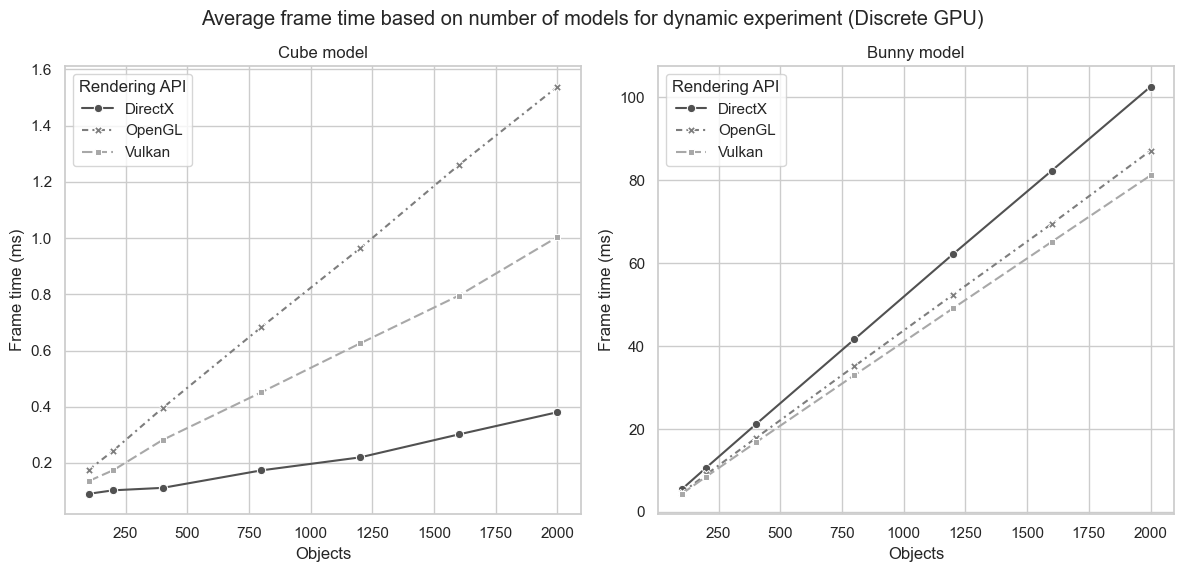

In [4]:
df_bunny_1 = df[(df["Model"] == "Bunny") & (df["Experiment"] == "1")]
df_cube_1 = df[(df["Model"] == "Cube") & (df["Experiment"] == "1")]
avg_frame_time_bunny_config_1 = {"function": plot_avg_frame_time, "data": df_bunny_1, "title": "Bunny model"}
avg_frame_time_cube_config_1 = {"function": plot_avg_frame_time, "data": df_cube_1, "title": "Cube model"}

plot_grid([avg_frame_time_cube_config_1, avg_frame_time_bunny_config_1],
          figsize=(12, 6),
          title="Average frame time based on number of models for dynamic experiment (Discrete GPU)",
          output="../Images/avg-frame-time-experiment-1-discrete.png")

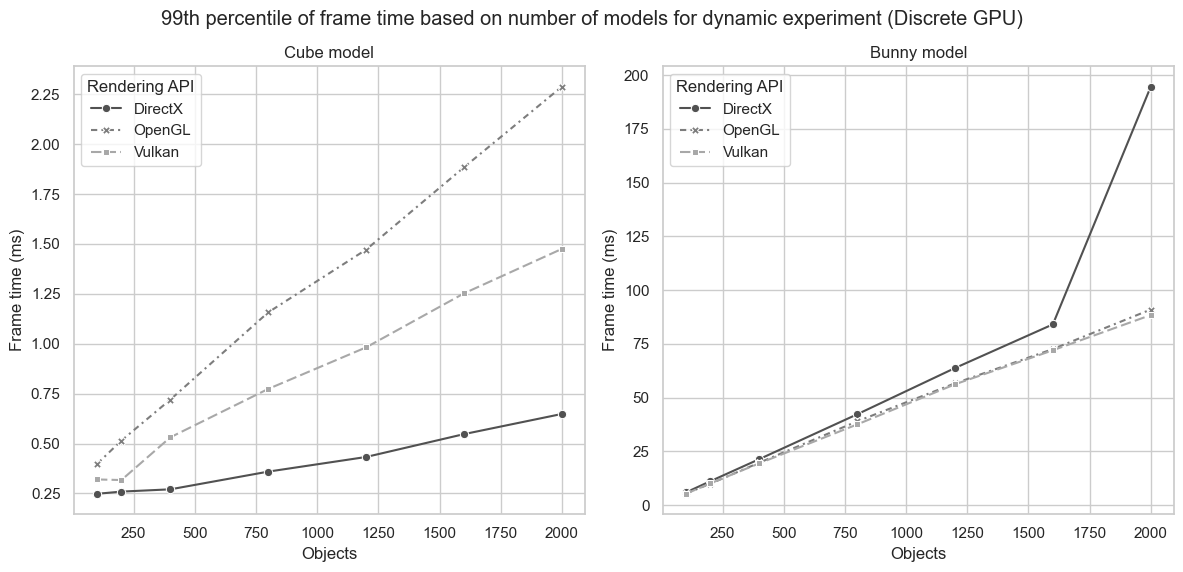

In [5]:
percentile_99_frame_time_bunny_config_1 = {"function": plot_99_percentile_frame_time, "data": df_bunny_1, "title": "Bunny model"}
percentile_99_frame_time_cube_config_1 = {"function": plot_99_percentile_frame_time, "data": df_cube_1, "title": "Cube model"}

plot_grid([percentile_99_frame_time_cube_config_1, percentile_99_frame_time_bunny_config_1],
          figsize=(12, 6),
          title="99th percentile of frame time based on number of models for dynamic experiment (Discrete GPU)",
          output="../Images/99-percentile-frame-time-experiment-1-discrete.png")

In [6]:
hardest_case = df[(df["Model"] == "Bunny") & (df["Experiment"] == "1") & (df["Objects count"] == 2000)][["Renderer", "Average FPS"]]
hardest_case.head()

,Renderer,Average FPS
11,DirectX,9.74812
39,OpenGL,11.47340
67,Vulkan,12.31740


In [7]:
hardest_case = df[(df["Model"] == "Cube") & (df["Experiment"] == "1") & (df["Objects count"] == 2000)][["Renderer", "Average FPS"]]
hardest_case.head()

,Renderer,Average FPS
25,DirectX,2626.570
53,OpenGL,649.918
81,Vulkan,995.974


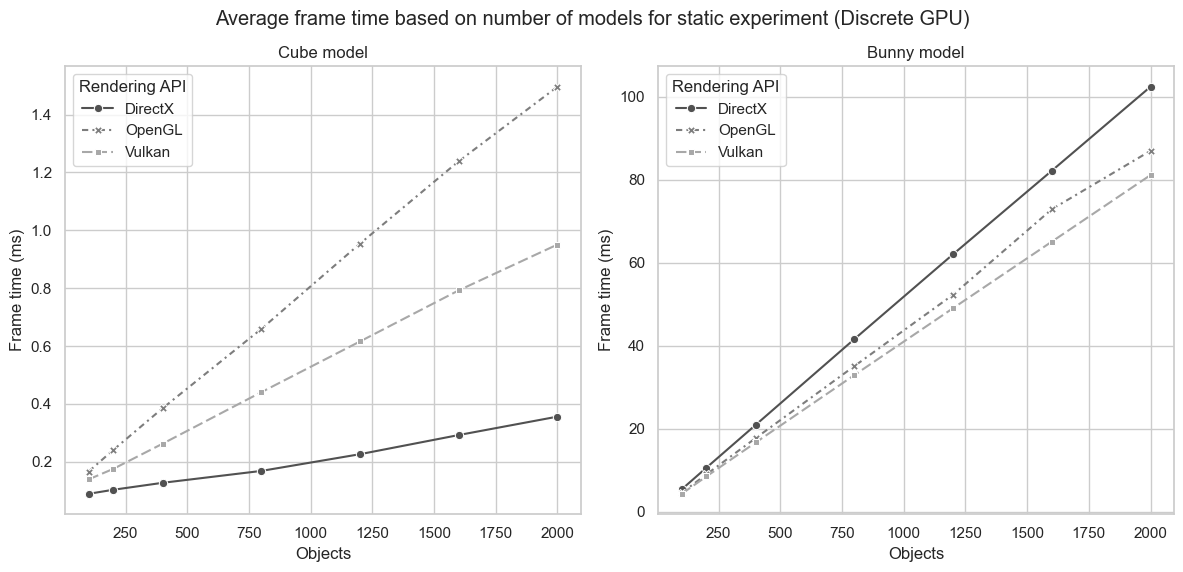

In [8]:
df_bunny_2 = df[(df["Model"] == "Bunny") & (df["Experiment"] == "2")]
df_cube_2 = df[(df["Model"] == "Cube") & (df["Experiment"] == "2")]
avg_frame_time_bunny_config_2 = {"function": plot_avg_frame_time, "data": df_bunny_2, "title": "Bunny model"}
avg_frame_time_cube_config_2 = {"function": plot_avg_frame_time, "data": df_cube_2, "title": "Cube model"}

plot_grid([avg_frame_time_cube_config_2, avg_frame_time_bunny_config_2],
          figsize=(12, 6),
          title="Average frame time based on number of models for static experiment (Discrete GPU)",
          output="../Images/avg-frame-time-experiment-2-discrete.png")

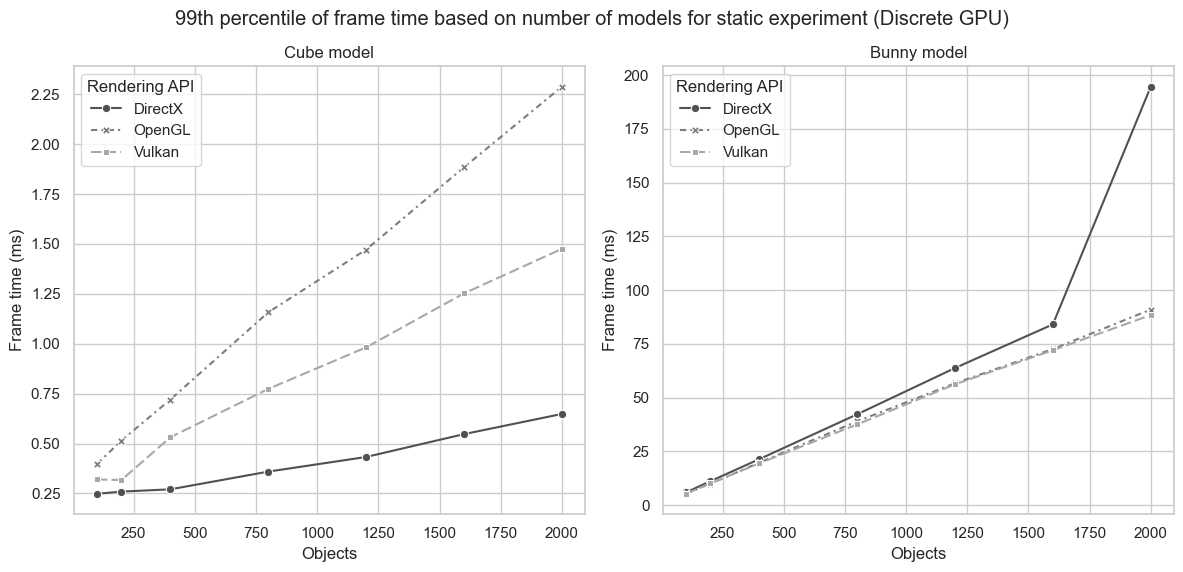

In [9]:
percentile_99_frame_time_bunny_config_2 = {"function": plot_99_percentile_frame_time, "data": df_bunny_1, "title": "Bunny model"}
percentile_99_frame_time_cube_config_2 = {"function": plot_99_percentile_frame_time, "data": df_cube_1, "title": "Cube model"}

plot_grid([percentile_99_frame_time_cube_config_2, percentile_99_frame_time_bunny_config_2],
          figsize=(12, 6),
          title="99th percentile of frame time based on number of models for static experiment (Discrete GPU)",
          output="../Images/99-percentile-frame-time-experiment-2-discrete.png")

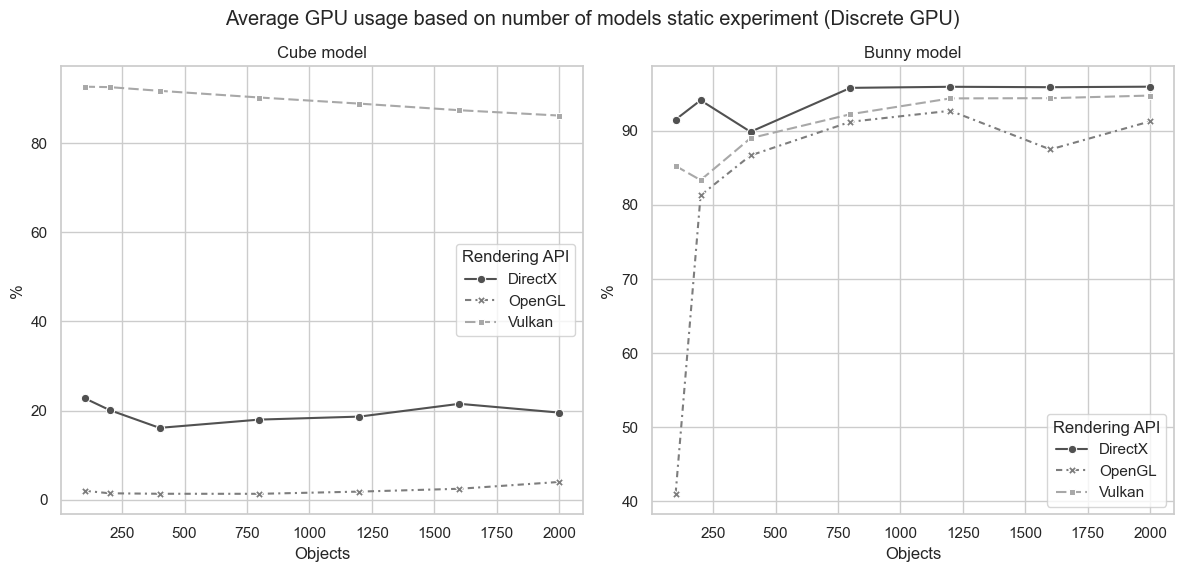

In [10]:
avg_gpu_usage_bunny_config = {"function": plot_avg_gpu_usage, "data": df_bunny_2, "title": "Bunny model"}
avg_gpu_usage_cube_config = {"function": plot_avg_gpu_usage, "data": df_cube_2, "title": "Cube model"}

plot_grid([avg_gpu_usage_cube_config, avg_gpu_usage_bunny_config],
          figsize=(12, 6),
          title="Average GPU usage based on number of models static experiment (Discrete GPU)",
          output="../Images/avg-gpu-usage-experiment-1-discrete.png")

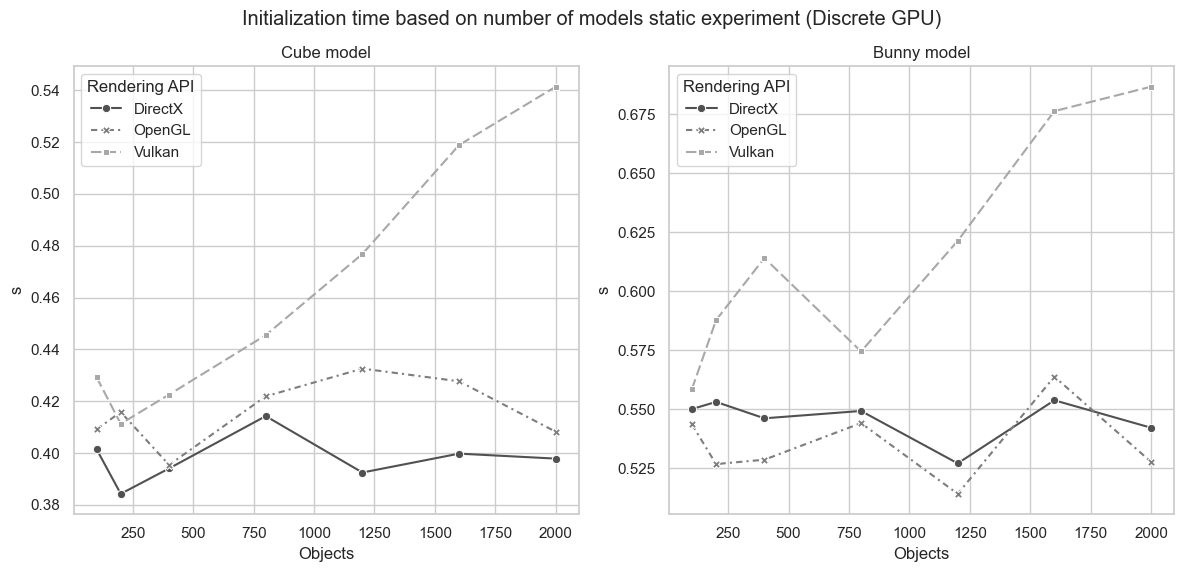

In [11]:
creation_time_bunny_config = {"function": plot_creation_time, "data": df_bunny_2, "title": "Bunny model"}
creation_time_cube_config = {"function": plot_creation_time, "data": df_cube_2, "title": "Cube model"}

plot_grid([creation_time_cube_config, creation_time_bunny_config],
          figsize=(12, 6),
          title="Initialization time based on number of models static experiment (Discrete GPU)",
          output="../Images/creation-time-experiment-1-discrete.png")

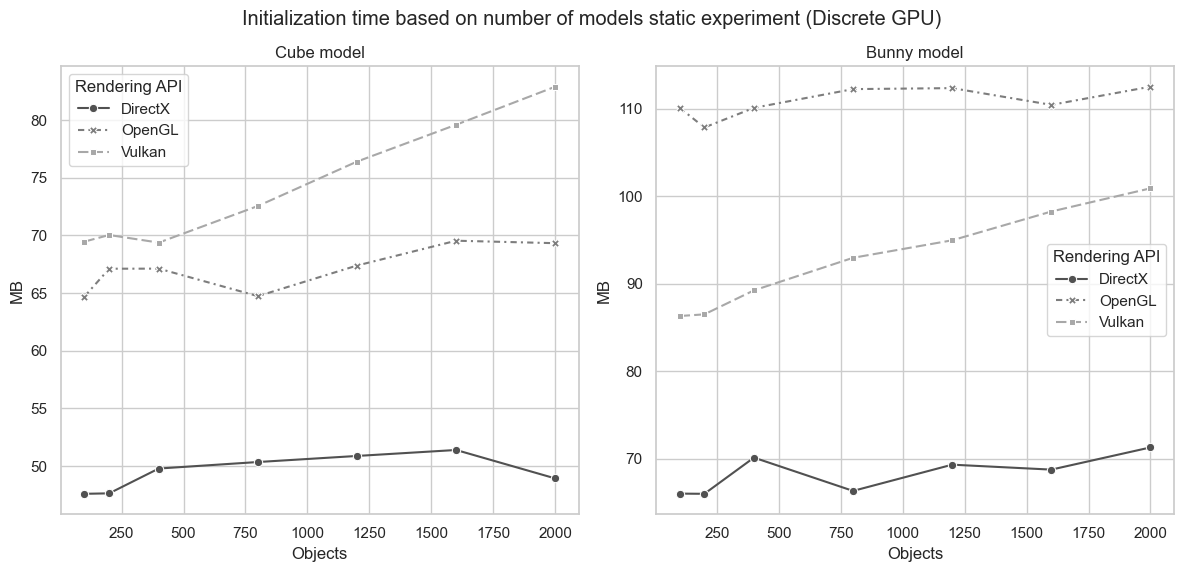

In [12]:
avg_ram_bunny_config = {"function": plot_avg_memory_usage, "data": df_bunny_2, "title": "Bunny model"}
avg_ram_cube_config = {"function": plot_avg_memory_usage, "data": df_cube_2, "title": "Cube model"}

plot_grid([avg_ram_cube_config, avg_ram_bunny_config],
          figsize=(12, 6),
          title="Initialization time based on number of models static experiment (Discrete GPU)",
          output="../Images/avg-ram-experiment-1-discrete.png")

In [13]:
hardest_case = df[(df["Model"] == "Bunny") & (df["Experiment"] == "2") & (df["Objects count"] == 2000)][["Renderer", "Average FPS"]]
hardest_case.head()

,Renderer,Average FPS
4,DirectX,9.75845
32,OpenGL,11.49040
60,Vulkan,12.31800


In [14]:
hardest_case = df[(df["Model"] == "Cube") & (df["Experiment"] == "2") & (df["Objects count"] == 2000)][["Renderer", "Average FPS"]]
hardest_case.head()

,Renderer,Average FPS
18,DirectX,2808.380
46,OpenGL,668.372
74,Vulkan,1051.810


In [15]:
repeated_folder ="../Statistics/RTX4060_Repeated"

def read_repeated_statistics(folder):
    data_list = []
    for filename in os.listdir(folder):
        if ".txt" not in filename:
            continue
        path = os.path.join(folder, filename)
        params = filename.split(".")[0].split("_")[1:]
        with open(path) as f:
            parts = f.read().split("\n\n\n")[:-1]
        for part in parts:
            data = parse_content(part.split("\n"))
            data["Experiment"] = params[3]
            data["Model"] = params[1]
            data_list.append(data)

    special_columns = ["Model", "Experiment", "Renderer"]
    ms_columns = [
        'Average frame time',
        'Median frame time',
        '99th percentile frame time',
        '1th percentile frame time'
    ]

    df = pd.DataFrame(data_list)
    for column in df.columns:
        if column in special_columns:
            continue
        df[column] = pd.to_numeric(df[column]) 

    for column in ms_columns:
        df[column] *= 1000.0

    return df

df = read_repeated_statistics(repeated_folder)
df.head()

,Renderer,Objects count,Total number of vertices,Creation time,Average CPU usage,Max CPU usage,Min CPU usage,Average GPU usage,Max GPU usage,Min GPU usage,...,Average GPU memory usage,Max GPU memory usage,Min GPU memory usage,Average FPS,Average frame time,Median frame time,99th percentile frame time,1th percentile frame time,Experiment,Model
0,DirectX,400.0,0.0,0.568482,12.0764,14.3793,8.38294,95.2579,99.0873,39.7314,...,35.5312,35.5312,35.5312,47.4479,21.0757,21.1170,21.6811,20.5178,2,Bunny
1,DirectX,400.0,0.0,0.527094,11.6141,14.0536,7.80814,95.2029,99.8268,39.1105,...,35.5312,35.5312,35.5312,47.4174,21.0893,21.1320,21.6974,20.3103,2,Bunny
2,DirectX,400.0,0.0,0.513738,12.1517,14.8309,9.08833,95.3564,99.9491,39.6975,...,35.5312,35.5312,35.5312,47.6019,21.0076,21.0714,21.6758,20.5458,2,Bunny
3,DirectX,400.0,0.0,0.523203,11.3721,14.5504,9.16489,95.2100,99.5049,39.5604,...,35.5312,35.5312,35.5312,47.7186,20.9562,21.0094,21.6047,20.5146,2,Bunny
4,DirectX,400.0,0.0,0.545533,11.7119,14.0341,8.89965,95.2302,99.6267,39.1999,...,35.5312,35.5312,35.5312,47.5062,21.0499,21.1101,21.6481,20.2766,2,Bunny


In [16]:
import matplotlib.patches as mpatches

def create_distribution_plot(data, config, output=None):
    plt.figure(figsize=(10, 6))
    
    hatches = {
        "Vulkan": "//",
        "OpenGL": "\\\\",
        "DirectX": "xx"
    }
    
    renderers = sorted(data["Renderer"].unique())
    palette = sns.color_palette(n_colors=len(renderers))
    color_mapping = dict(zip(renderers, palette))
    
    ax = sns.histplot(
        data=data,
        x=config["x_column"],
        hue="Renderer",
        bins=int((data[config["x_column"]].max() - data[config["x_column"]].min()) / config["binwidth"]),
        multiple="dodge",
        edgecolor="black",
        palette=color_mapping
    )
    
    for idx, container in enumerate(ax.containers):
        if idx < len(renderers):
            renderer = renderers[idx]
            for patch in container:
                patch.set_hatch(hatches.get(renderer, ""))
    
    custom_handles = []
    for r in renderers:
        patch = mpatches.Patch(facecolor=color_mapping[r],
                               edgecolor="black",
                               hatch=hatches[r],
                               label=r)
        custom_handles.append(patch)
    
    ax.legend(handles=custom_handles, loc="upper left", bbox_to_anchor=(0.00, 1.0), title="Rendering API", frameon=True)
    x_min = data[config['x_column']].min()
    x_max = data[config['x_column']].max()
    plt.xlim(x_min - config["plot_range"], x_max + config["plot_range"])
    plt.title(config["title"])
    plt.xlabel(config["x_label"])
    plt.ylabel("Count")
    if output is not None:
        plt.savefig(output, dpi=100)
    plt.show()


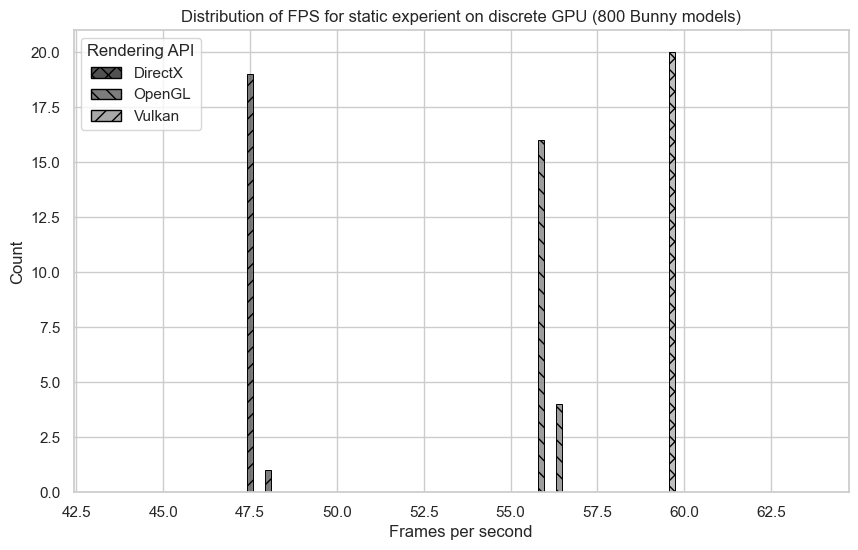

In [17]:
avg_fps_config = {"x_column": "Average FPS", "x_label": "Frames per second", "binwidth": 0.5, "title": "Distribution of FPS for static experient on discrete GPU (800 Bunny models)", "plot_range": 5} 
create_distribution_plot(df, avg_fps_config, output="../Images/avg-fps-repeated-experiment-2-discrete.png")

# Integrated GPU

In [18]:
directory_path = "../Statistics/Integrated_1280_720/"
df = read_statistics(directory_path)
df = df.sort_values(by="Renderer")
df.head()

,Renderer,Objects count,Total number of vertices,Creation time,Average CPU usage,Max CPU usage,Min CPU usage,Average GPU usage,Max GPU usage,Min GPU usage,...,Average GPU memory usage,Max GPU memory usage,Min GPU memory usage,Average FPS,Average frame time,Median frame time,99th percentile frame time,1th percentile frame time,Experiment,Model
0,DirectX,40.0,0.0,1.080180,5.75272,7.96707,3.32333,91.9439,95.3537,40.0388,...,29.6328,29.6328,29.6328,31.1479,32.10490,31.9259,37.2592,31.2973,1,Bunny
27,DirectX,80.0,0.0,0.877806,66.67480,99.21980,53.64880,83.8346,88.6126,41.5978,...,17.5742,17.5742,17.5742,817.4470,1.22332,1.2138,2.0254,0.6328,2,Cube
26,DirectX,60.0,0.0,1.056070,83.20270,100.00000,39.54270,86.1743,92.5642,41.9711,...,17.3065,17.3203,17.2031,825.8910,1.21081,1.2111,1.9785,0.6179,2,Cube
25,DirectX,20.0,0.0,1.028930,97.05220,100.00000,67.84260,88.5420,91.7093,43.5233,...,17.2734,17.2734,17.2734,898.4790,1.11299,1.0884,1.7166,0.6192,1,Cube
24,DirectX,4.0,0.0,1.048740,97.45200,100.00000,91.04760,89.6813,92.9151,44.1604,...,17.2500,17.2500,17.2500,945.7230,1.05739,1.0178,1.9423,0.4978,2,Cube


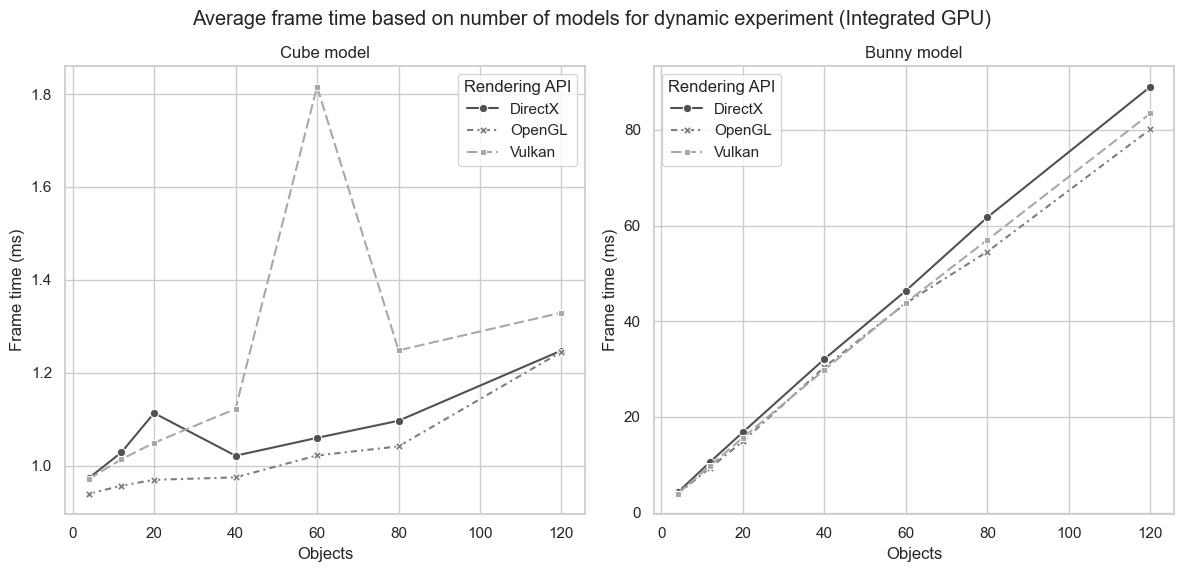

In [19]:
df_bunny_1 = df[(df["Model"] == "Bunny") & (df["Experiment"] == "1")]
df_cube_1 = df[(df["Model"] == "Cube") & (df["Experiment"] == "1")]
avg_frame_time_bunny_config_1 = {"function": plot_avg_frame_time, "data": df_bunny_1, "title": "Bunny model"}
avg_frame_time_cube_config_1 = {"function": plot_avg_frame_time, "data": df_cube_1, "title": "Cube model"}

plot_grid([avg_frame_time_cube_config_1, avg_frame_time_bunny_config_1],
          figsize=(12, 6),
          title="Average frame time based on number of models for dynamic experiment (Integrated GPU)",
          output="../Images/avg-frame-time-experiment-1-integrated.png")

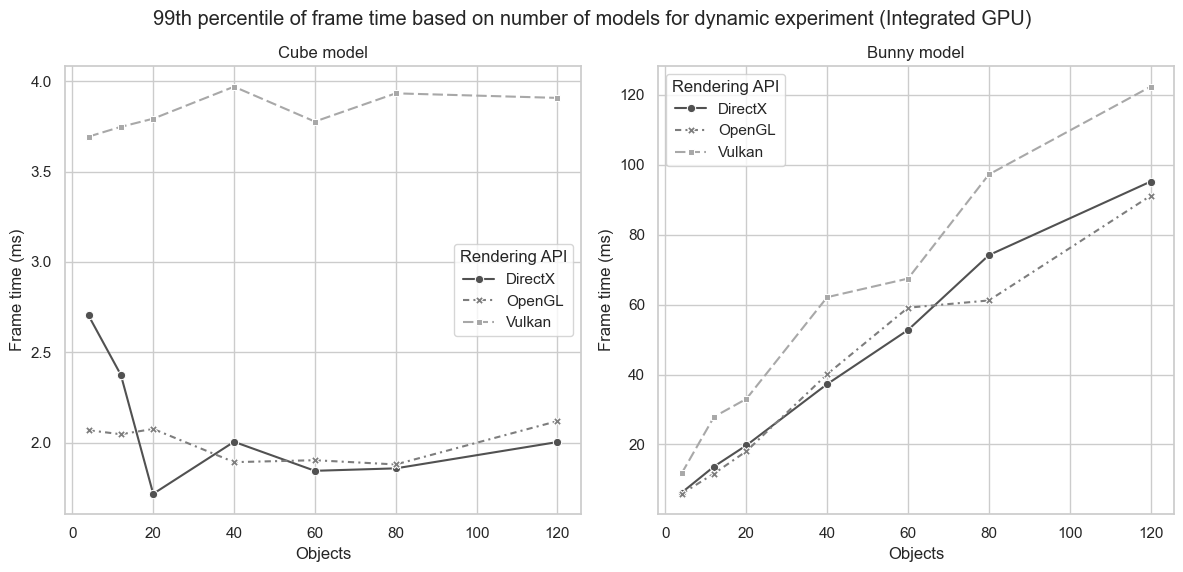

In [20]:
percentile_99_frame_time_bunny_config_1 = {"function": plot_99_percentile_frame_time, "data": df_bunny_1, "title": "Bunny model"}
percentile_99_frame_time_cube_config_1 = {"function": plot_99_percentile_frame_time, "data": df_cube_1, "title": "Cube model"}

plot_grid([percentile_99_frame_time_cube_config_1, percentile_99_frame_time_bunny_config_1],
          figsize=(12, 6),
          title="99th percentile of frame time based on number of models for dynamic experiment (Integrated GPU)",
          output="../Images/99-percentile-frame-time-experiment-1-integrated.png")

In [21]:
hardest_case = df[(df["Model"] == "Bunny") & (df["Experiment"] == "1") & (df["Objects count"] == 120)][["Renderer", "Average FPS"]]
hardest_case.head()

,Renderer,Average FPS
7,DirectX,11.2296
35,OpenGL,12.4770
63,Vulkan,11.9830


In [22]:
hardest_case = df[(df["Model"] == "Cube") & (df["Experiment"] == "1") & (df["Objects count"] == 120)][["Renderer", "Average FPS"]]
hardest_case.head()

,Renderer,Average FPS
21,DirectX,801.456
49,OpenGL,803.247
77,Vulkan,752.325


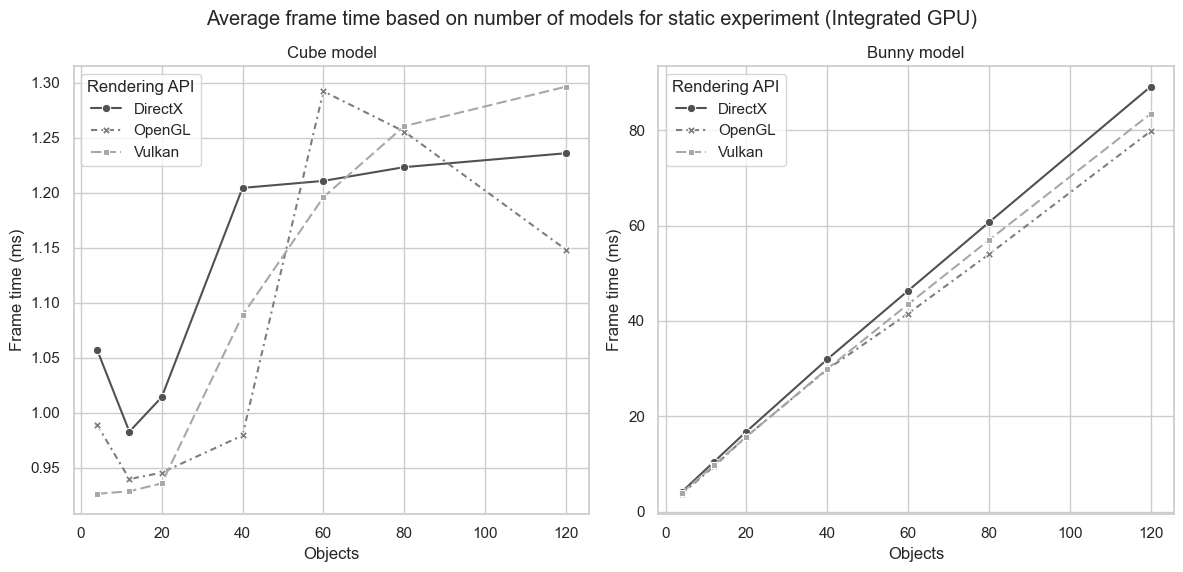

In [23]:
df_bunny_2 = df[(df["Model"] == "Bunny") & (df["Experiment"] == "2")]
df_cube_2 = df[(df["Model"] == "Cube") & (df["Experiment"] == "2")]
avg_frame_time_bunny_config_2 = {"function": plot_avg_frame_time, "data": df_bunny_2, "title": "Bunny model"}
avg_frame_time_cube_config_2 = {"function": plot_avg_frame_time, "data": df_cube_2, "title": "Cube model"}

plot_grid([avg_frame_time_cube_config_2, avg_frame_time_bunny_config_2],
          figsize=(12, 6),
          title="Average frame time based on number of models for static experiment (Integrated GPU)",
          output="../Images/avg-frame-time-experiment-2-integrated.png")

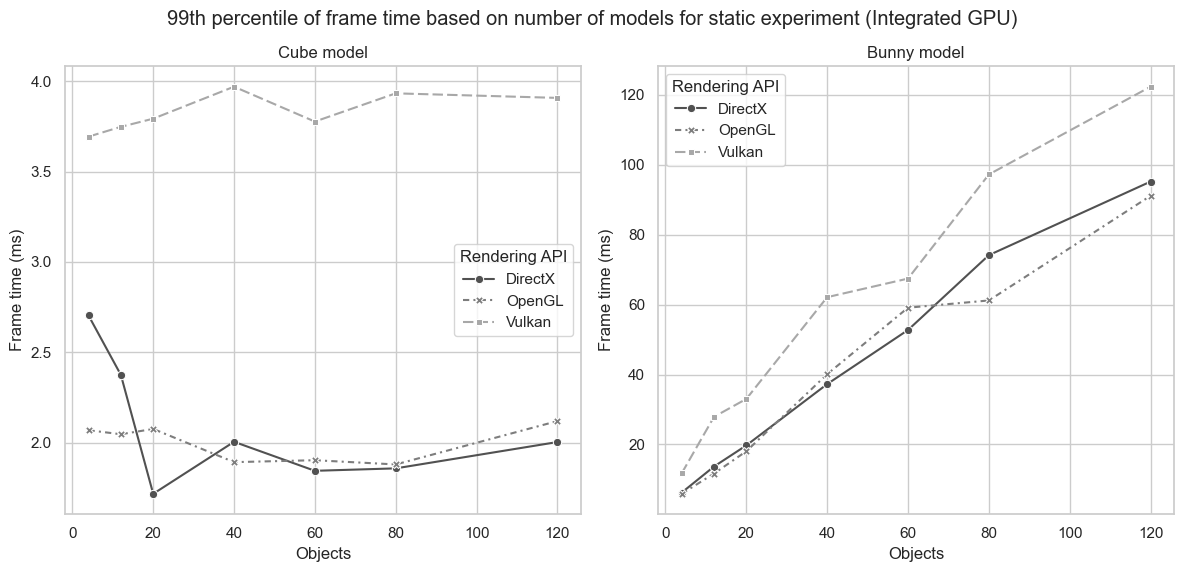

In [24]:
percentile_99_frame_time_bunny_config_2 = {"function": plot_99_percentile_frame_time, "data": df_bunny_1, "title": "Bunny model"}
percentile_99_frame_time_cube_config_2 = {"function": plot_99_percentile_frame_time, "data": df_cube_1, "title": "Cube model"}

plot_grid([percentile_99_frame_time_cube_config_2, percentile_99_frame_time_bunny_config_2],
          figsize=(12, 6),
          title="99th percentile of frame time based on number of models for static experiment (Integrated GPU)",
          output="../Images/99-percentile-frame-time-experiment-2-integrated.png")

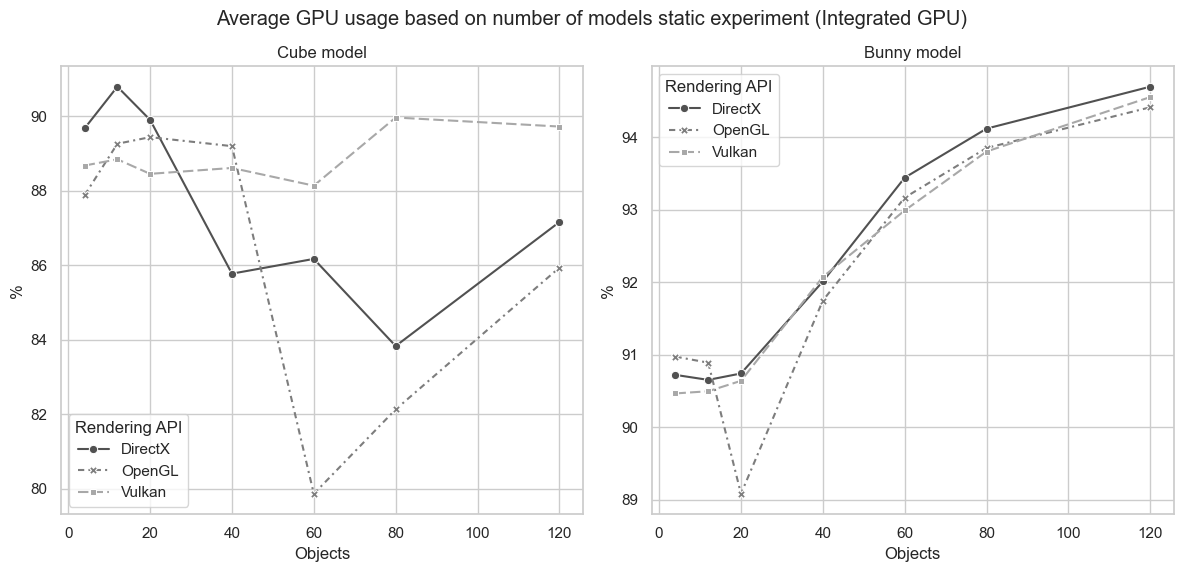

In [25]:
avg_gpu_usage_bunny_config = {"function": plot_avg_gpu_usage, "data": df_bunny_2, "title": "Bunny model"}
avg_gpu_usage_cube_config = {"function": plot_avg_gpu_usage, "data": df_cube_2, "title": "Cube model"}

plot_grid([avg_gpu_usage_cube_config, avg_gpu_usage_bunny_config],
          figsize=(12, 6),
          title="Average GPU usage based on number of models static experiment (Integrated GPU)",
          output="../Images/avg-gpu-usage-experiment-1-integrated.png")

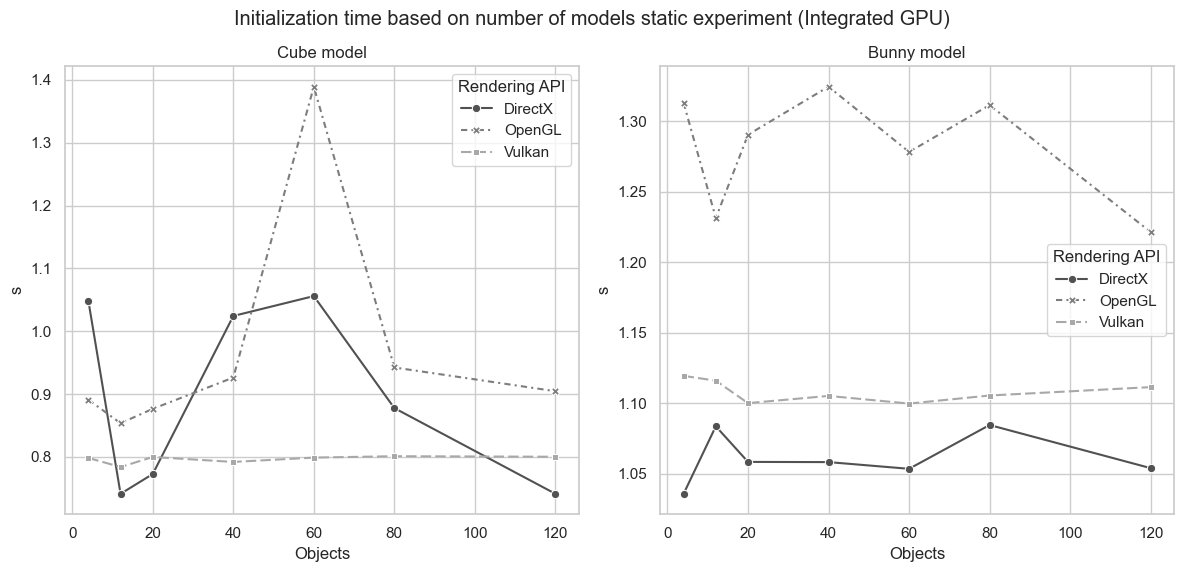

In [26]:
creation_time_bunny_config = {"function": plot_creation_time, "data": df_bunny_2, "title": "Bunny model"}
creation_time_cube_config = {"function": plot_creation_time, "data": df_cube_2, "title": "Cube model"}

plot_grid([creation_time_cube_config, creation_time_bunny_config],
          figsize=(12, 6),
          title="Initialization time based on number of models static experiment (Integrated GPU)",
          output="../Images/creation-time-experiment-1-integrated.png")

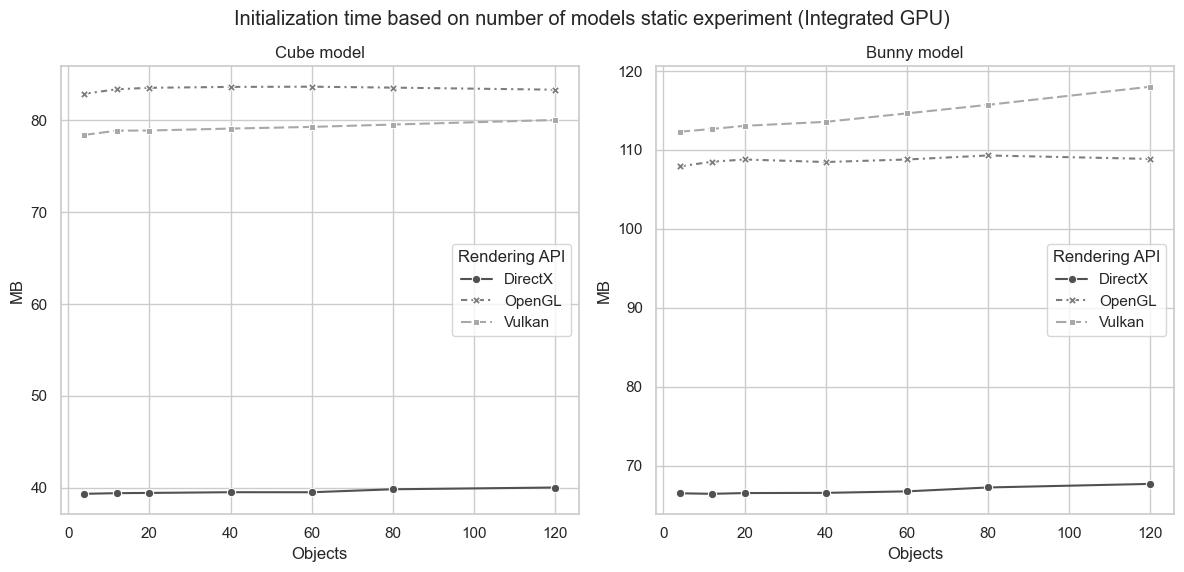

In [27]:
avg_ram_bunny_config = {"function": plot_avg_memory_usage, "data": df_bunny_2, "title": "Bunny model"}
avg_ram_cube_config = {"function": plot_avg_memory_usage, "data": df_cube_2, "title": "Cube model"}

plot_grid([avg_ram_cube_config, avg_ram_bunny_config],
          figsize=(12, 6),
          title="Initialization time based on number of models static experiment (Integrated GPU)",
          output="../Images/avg-ram-experiment-1-integrated.png")

In [28]:
hardest_case = df[(df["Model"] == "Bunny") & (df["Experiment"] == "2") & (df["Objects count"] == 120)][["Renderer", "Average FPS"]]
hardest_case.head()

,Renderer,Average FPS
1,DirectX,11.2238
29,OpenGL,12.5386
57,Vulkan,11.9904


In [29]:
hardest_case = df[(df["Model"] == "Cube") & (df["Experiment"] == "2") & (df["Objects count"] == 120)][["Renderer", "Average FPS"]]
hardest_case.head()

,Renderer,Average FPS
15,DirectX,809.080
43,OpenGL,870.821
71,Vulkan,771.315
